# Clean up of idsp dataset take by idsp_parser_camelot

* Remove duplicate rows. Camelot takes the full table on each page, replicated headers many times.
* Split the merged cases/deaths column for early years
* Move data located in the wrong column to the correct column
* Remove text characters from numerical columns
* Unify the datetime column format
* Unify the diseases
* Unify the state, district etc



In [87]:
# import geopandas as gpd
import pandas as pd
import random
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from matplotlib.colors import SymLogNorm
import scipy as sp
from datetime import datetime
import shapely as sh
from fuzzywuzzy import fuzz
from tqdm import tqdm
import re

%matplotlib notebook

In [2]:
def fuzzy_match(hypotheses, target, thresh=5):
    # returns the hypothesis which best matches the target
    match = []

    # build a list of (score, state) tuples
    for h in hypotheses:
        match.append((fuzz.token_sort_ratio(h,target), h))

    # sort the list of tuples to take the state with highest score
    match.sort()
    
    if match[-1][0] >= thresh:
        return match[-1][-1]
    elif thresh == None:
        return match[-1]


Lets explore these datasets. _outbreaks_ has text information regarding outbreaks; when, where, what, how many and current status. There is also a comments field which contains potentially useful but unstructured data.

In [56]:
df = pd.read_csv("idsp_database_remote.csv")

# Get an idea of the completeness of the raw dataset

## Drop duplicate rows


In [4]:
df.drop_duplicates(inplace=True)

<IPython.core.display.Javascript object>


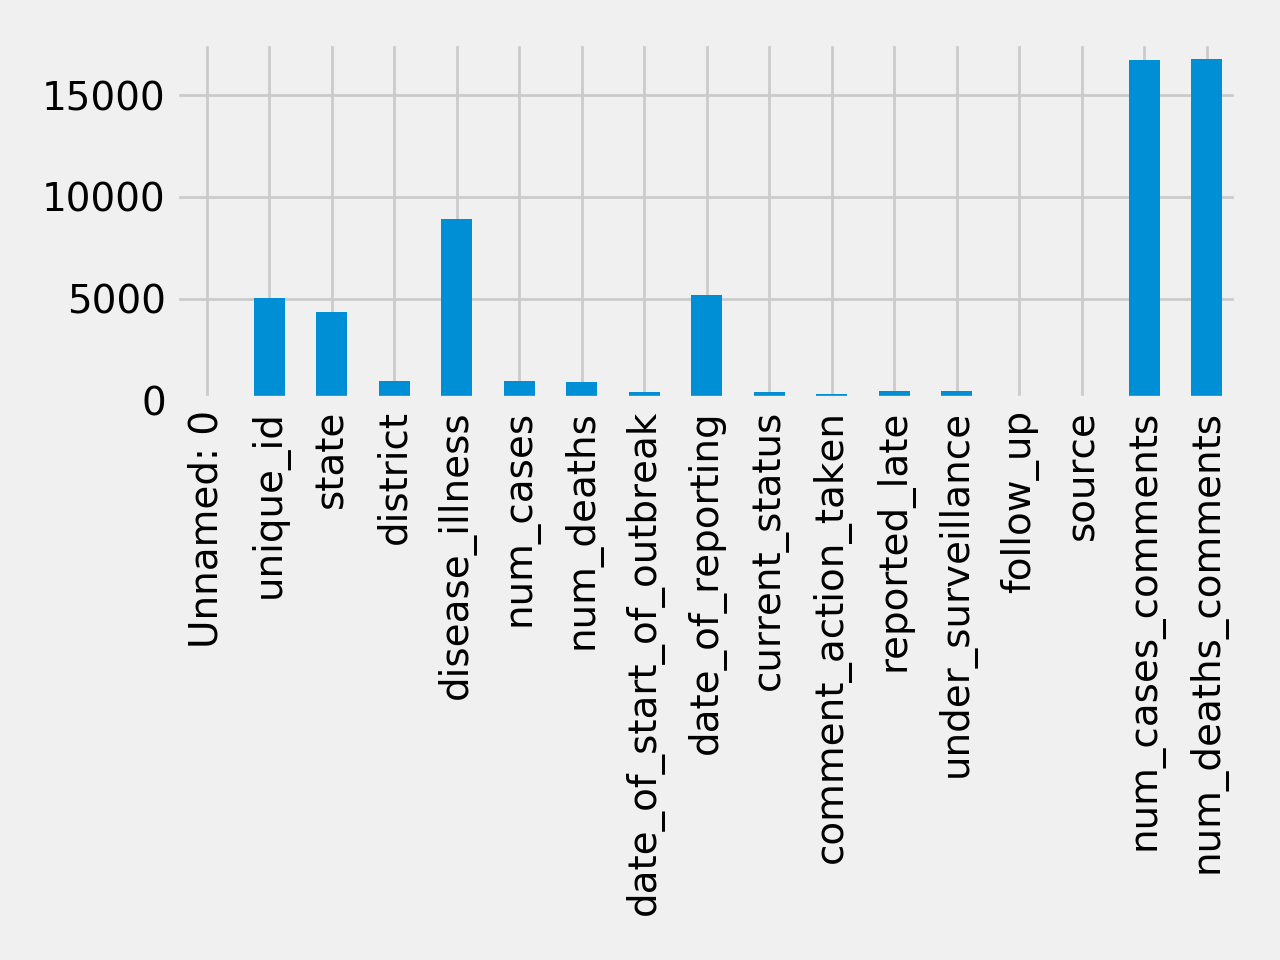

In [48]:
# missing data by column
plt.figure()
df.isna().sum().plot.bar(ax=plt.gca())
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


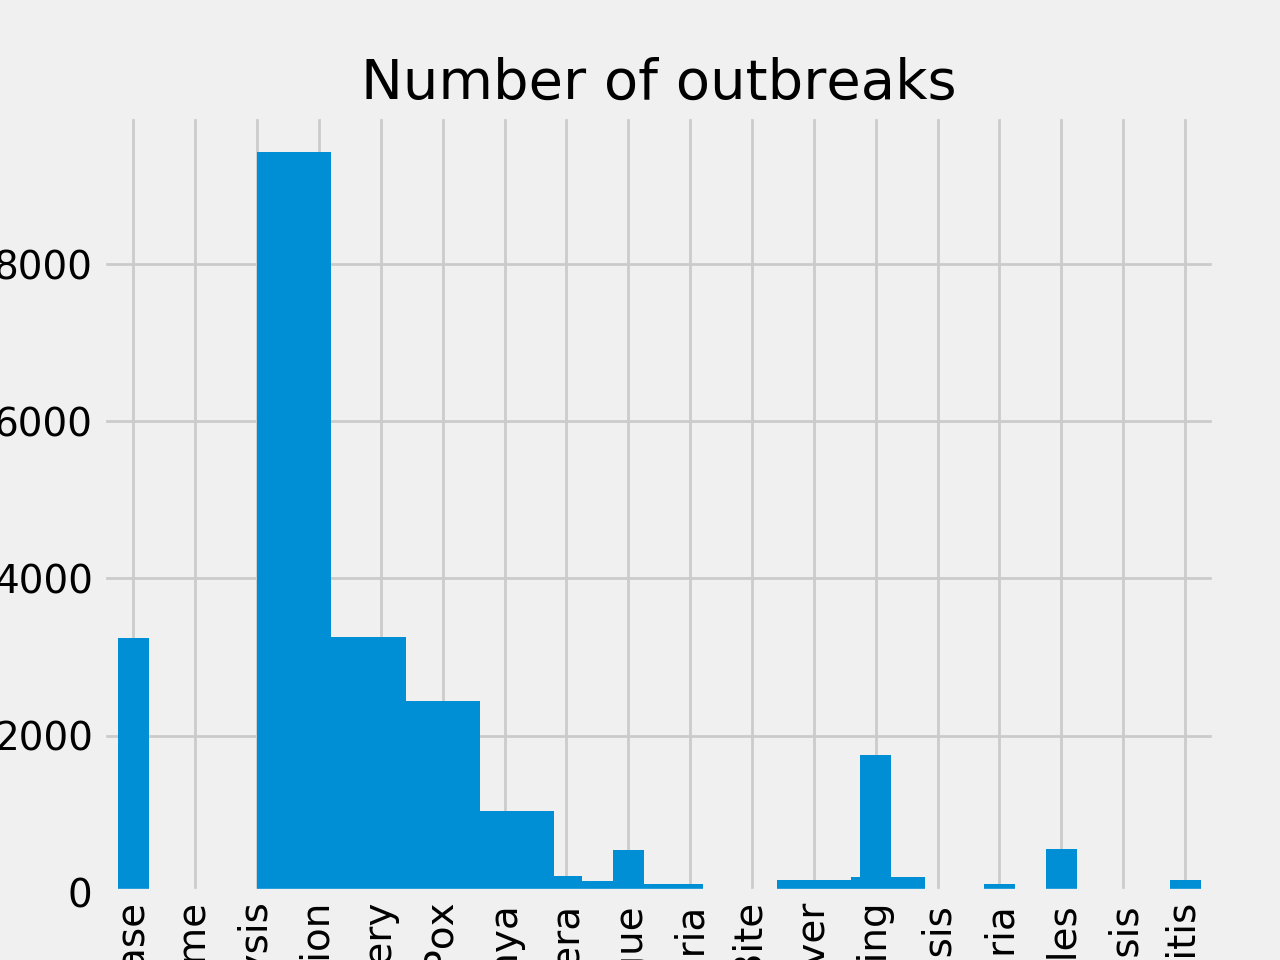

In [49]:
num_nans=[]
for i, row in df.iterrows():
    num_nans.append(row.isna().sum())
    
plt.figure()
plt.title('Completeness by row')
plt.hist(num_nans)
plt.xlabel('No. missing values')
plt.ylabel('No. rows')
plt.show()

## disease matching

In [213]:
with open('disease_names.txt','r') as f:
    disease_names = f.read()
    
disease_names = disease_names.split('\n')+['Snake bite']

In [214]:
df.disease_illness = df.disease_illness.apply(lambda x:fuzzy_match(disease_names,x))

In [215]:
df.disease_illness.unique()

array(['Measles', 'Chicken Pox', 'Cholera', 'Acute Diarrheal Disease',
       'Food Poisoning', 'Enteric Fever', 'Dengue', 'Chikungunya',
       'Leptospirosis', 'Viral Hepatitis', 'Fever Of Unknown Origin',
       'Any Other State Specific Disease', 'Malaria', 'Pertussis', None,
       'Pneumonia', 'Snake bite', 'Diphtheria',
       'Acute Encephalitis Syndrome', 'Acute Respiratory Infection',
       'Acute Flaccid Paralysis', 'Bacillary Dysentery', 'Dog Bite',
       'Meningitis', 'Unusual Syndromes Not Captured Above'], dtype=object)

## Split cases/deaths columns

In [19]:
df.date_of_reporting.fillna('')

for i, row in df.iterrows():
    try:
        # split cases / deaths column
        # use regex to extract digits
#         cases, deaths = row.num_cases.split('/')
        cases, deaths = re.findall('\d+',row.num_cases)
        # shuffle right dates to correct columns
        date_outbreak = row.num_deaths
        date_reporting = row.date_of_start_of_outbreak

        for j, var in enumerate(['num_cases',
                    'num_deaths',
                    'date_of_start_of_outbreak',
                    'date_of_reporting'
                   ]):
            df.at[i,var] = [int(cases),int(deaths),date_outbreak,date_reporting][j]
    except:
        pass

### Comments in the num_cases and num_deaths row

In [20]:
df['num_cases_comments'] = None

In [21]:
def get_comments(x):
    try:
        return re.findall('(?<=\()[\w\s]+(?!=\))',x)[0]
    except:
        return None

In [22]:
df['num_cases_comments'] = df['num_cases'].apply(lambda x:get_comments(x))
df['num_deaths_comments'] = df['num_deaths'].apply(lambda x:get_comments(x))

Get misplaced diseases...

## Convert num_cases, num_deaths to numeric

## datetime

Only really concerned with start date.

In [25]:
print(f'number of nan dates = {df.date_of_start_of_outbreak.isna().sum()}')
print(f'number of unique dates = {df.date_of_start_of_outbreak.unique().shape[0]}')
print(f'number of invalid dates = {pd.to_datetime(df.date_of_start_of_outbreak, errors="coerce").isna().sum()-df.date_of_start_of_outbreak.isna().sum()}')
print(f'number of duplicated dates = {df.date_of_start_of_outbreak.duplicated().sum()}')


number of nan dates = 414
number of unique dates = 3977
number of invalid dates = 438
number of duplicated dates = 12836


In [27]:

# set columns to type integer
def extract_digits(x):
    try:
        return int(re.findall('\d+',str(x))[0])
    except:
        return x

# df[['num_cases','num_deaths']] = df[['num_cases','num_deaths']].apply(extract_digits)

In [28]:
df['num_cases'] = pd.to_numeric(df.num_cases, errors='coerce')
df['num_deaths'] = pd.to_numeric(df.num_deaths, errors='coerce')

## datetime conversion

csv cannot save anything except string, so interpretation as datetime object is needed everytime..

In [29]:
df['date_of_start_of_outbreak'] = pd.to_datetime(df['date_of_start_of_outbreak'], errors='ignore')
df['date_of_reporting'] = pd.to_datetime(df['date_of_reporting'], errors='ignore')

## Disease matching
Use fuzzy match to get all the variations of spelling

In [30]:
with open('disease_names.txt','r') as f:
    disease_names = f.read().split('\n')
df.disease_illness = df.disease_illness.apply(lambda x:fuzzy_match(disease_names, str(x), thresh=90))

<IPython.core.display.Javascript object>


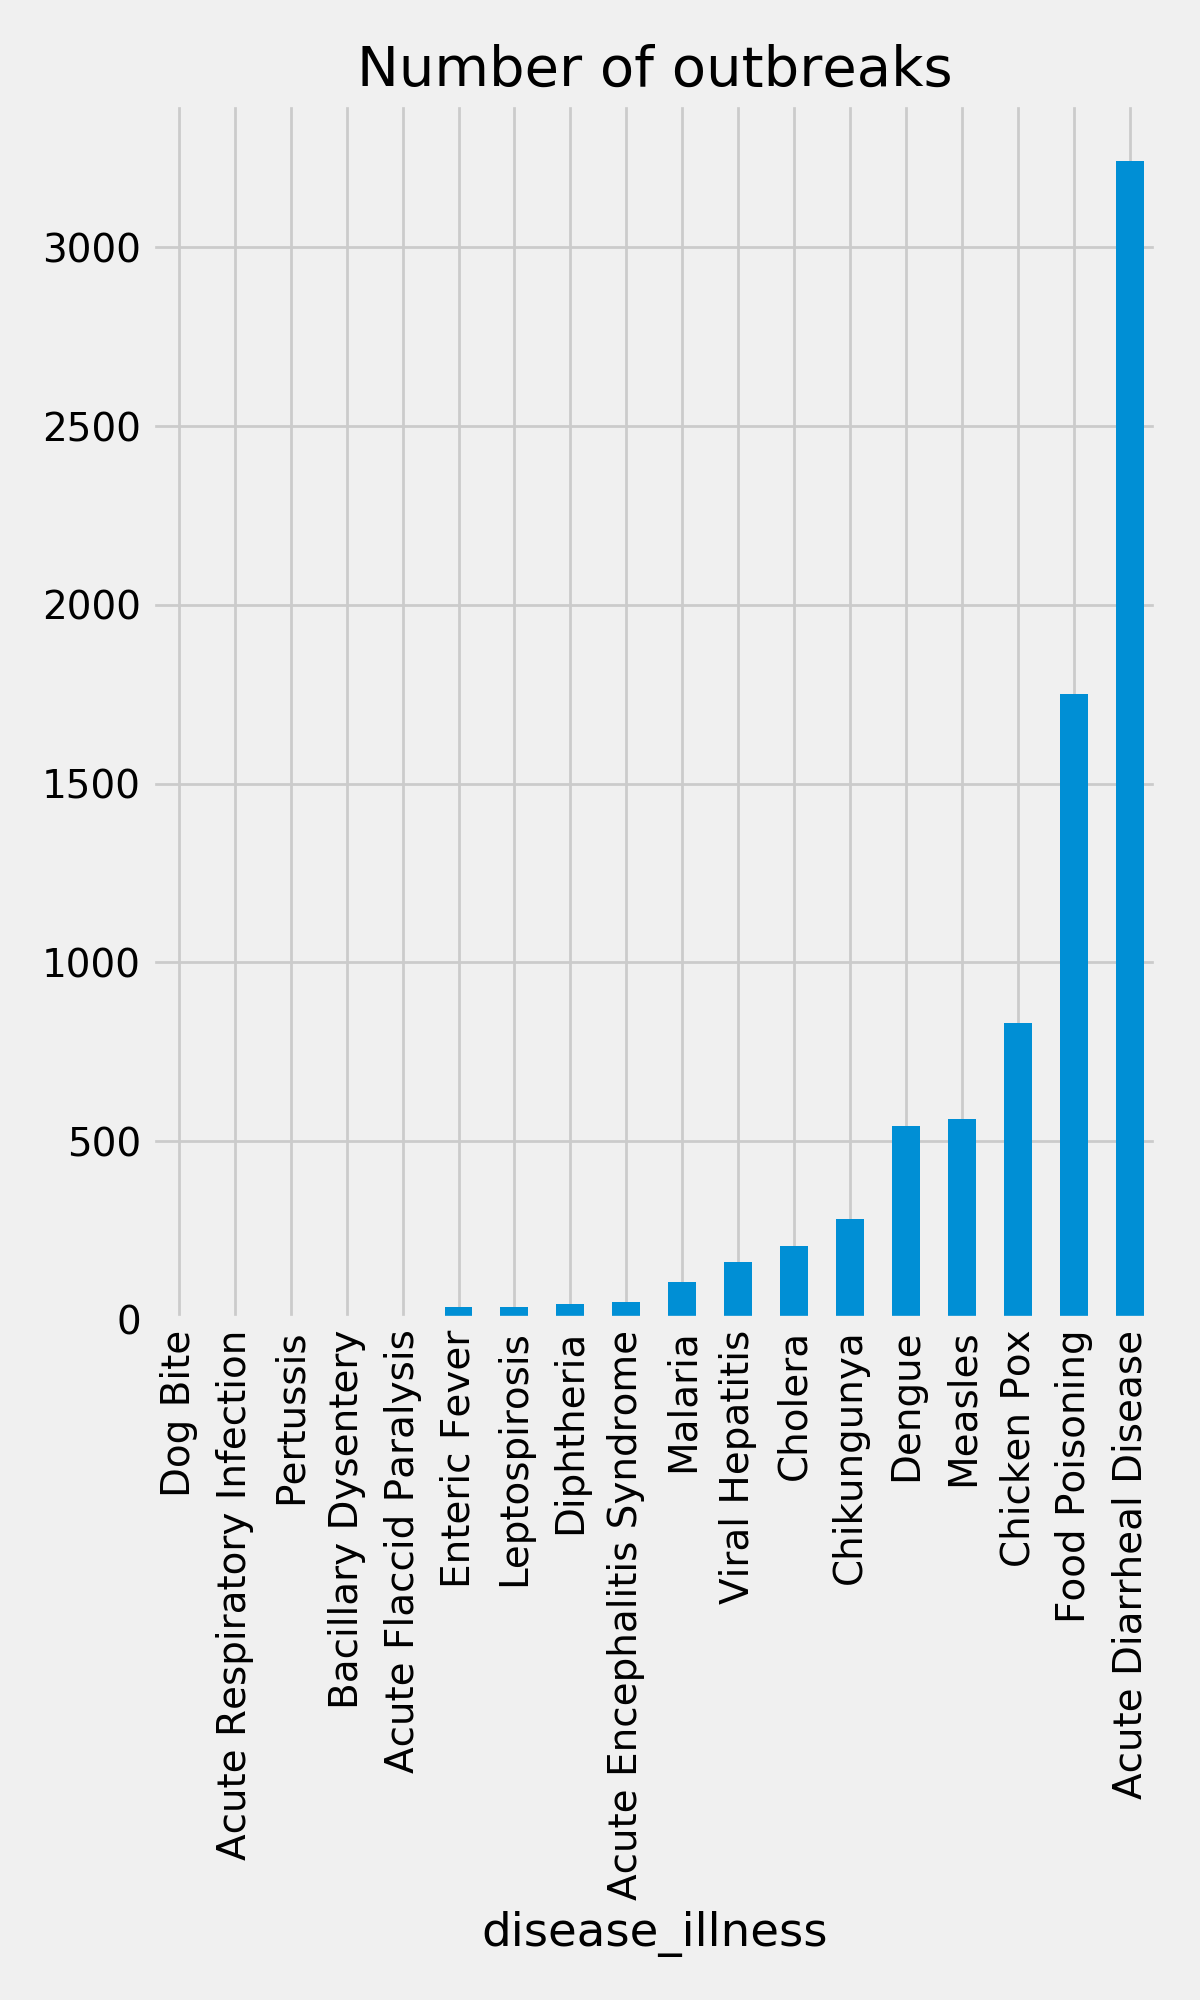

In [54]:
plt.figure(figsize=(6,10))
df.groupby('disease_illness')['Unnamed: 0'].count().sort_values().plot.bar(title='Number of outbreaks')
plt.tight_layout()

## Write to file

In [106]:
from datetime import datetime as dt
df.to_csv(f'idsp_database_camelot_{dt.today()}.csv')

# Adding the geospatial element

The administrative boundaries from GADM.org are merged with the outbreak data by the state and district columns. This is complicated by shifting boundaries over time and variations in spelling.

`idsp_parser.py` includes a fuzzy matching routine which gets the districts and states to match those of the GADM level 2 admin areas. This is done in a state, district dictionary method which is robust against matching districts from one state with another state. But could be a problem because it can match similar but different district names.

Locations are a big issue:

* Changing boundaries
* Variations in spelling
* Missing entries
* Sub district locations recorded in the district column

In [67]:
import geopandas as gpd

ind_2 = gpd.read_file('/Users/Angus_Laurenson/ownCloud/PML/PODCAST/INDIA/state_district_shapes/gadm36_IND_2.shp')
ind_3 = gpd.read_file('/Users/Angus_Laurenson/ownCloud/PML/PODCAST/INDIA/state_district_shapes/gadm36_IND_3.shp')

## Number of unique state district pairs

In [71]:
print(f'The number of raw string unique locations in outbreak data = { pd.Series(df.state + " " + df.district).dropna().unique().shape[0] }')
print(f'The number of available sub district locations = {ind_3.shape[0]}')
print(f'The number of available district locations = {ind_2.shape[0]}')

The number of raw string unique locations in outbreak data = 1684
The number of available sub district locations = 2340
The number of available district locations = 666


In [79]:
print(f'The size of the set of outbreak locations that match districts {len(list(set(df.district).intersection(set(ind_3.NAME_2))))}')

The size of the set of outbreak locations that match districts 559


In [80]:
print(f'The size of the set of outbreak locations that match sub-district not district {len(list(set(df.district).intersection(set(ind_3.NAME_3)).difference(set(df.district).intersection(set(ind_3.NAME_2)))))}')


The size of the set of outbreak locations that match sub-district not district 49


These are predominantly cities and represent a significant number of records that we can capture by checking against sub-district levels data as each of these in principle correspond to many different outbreaks.

We should first check districts against level 3, then level 2, superceeding the first match if the district matches level 2. These check are direct comparisons.

States are then matched. If the state is missing, which does occur, then the state should be inferred by the district. However, some districts from different states have the exact same name, in that case the state should not be assumed in the same manner. Instead, after the states are inferred in this way, the remaining missing states can be filled using ffill() or bfill() methods.

The first round of direct matching of states and districts should be followed up by a fuzzy matching round. Which matches similar strings. In order to the data to be auditable, the match score and original district should be recorded in new columns

```
df['district'] ---> df[['district','district_score','original_district']]
```



In [82]:
ind_3.NAME_1 = ind_3.NAME_1.apply(lambda x:x.title())
ind_3.NAME_2 = ind_3.NAME_2.apply(lambda x:x.title())
ind_3.NAME_3 = ind_3.NAME_3.apply(lambda x:x.title())

In [83]:
# create empty columns for filling with level names
df['NAME_1'] = None
df['NAME_2'] = None
df['NAME_3'] = None

## Primary direct matching

In [85]:
# First check for direct matches,
# at sub-district, district and state levels

for i, row in df.iterrows():
    
    # sub district level
    if row.district in set(ind_3.NAME_3):
        temp = ind_3[ind_3.NAME_3 == row.district].iloc[0]
        df.at[i,'NAME_2'] = temp['NAME_2']
        df.at[i,'NAME_3'] = temp['NAME_3']
        
    # superceed at district level
    if row.district in set(ind_3.NAME_2):
        df.at[i,'NAME_2'] = row.district
        df.at[i,'NAME_3'] = None
    
    # match states
    if row.state in set(ind_3.NAME_1):
        temp = ind_3[ind_3.NAME_2 == row.state]
        df.at[i,'NAME_1'] = row.state

## Secondary fuzzy matching

This process depends on the threshold. Low threshold increases true and false positive rates, low threshold deceases true and false positive rates.

In [88]:
# Fuzzy matching to get the different spellings of same place
# For example, Yadgiri --> Yadgir
# Default threshold for a match is 95 out of 100
for i, row in tqdm(df.iterrows()):
    
    # sub district level
    
    if row.NAME_3 == None:
#         print('# SUB DISTRICT:')
        match = fuzzy_match(ind_3.NAME_3, 
                            row.district,
                            thresh=90)
#         print(row.district,'---->',match)
        df.at[i,'NAME_3'] = match
        
    # district level
    if row.NAME_2 == None:
#         print('# DISTRICT:')
        match = fuzzy_match(list(set(ind_3.NAME_2)), 
                            row.district,
                            thresh=90)
#         print(row.district,'---->',match)
        df.at[i,'NAME_2'] = match
        df.at[i,'NAME_3'] = None

    # state level
    if row.NAME_1 == None:
#         print('# STATE:')
        match = fuzzy_match(list(set(ind_3.NAME_1)), 
                            row.state,
                            thresh=90)
#         print(row.state,'---->',match)
        df.at[i,'NAME_1'] = match

18160it [14:26, 20.97it/s]


In [95]:
print(f'The number of unique location before fuzzy matching = {pd.Series(df.state + df.district).unique().shape[0]}')
print(f'The number of unique locations after fuzzy matching = {pd.Series(df.NAME_1 + df.NAME_2).unique().shape[0]}')

The number of unique location before fuzzy matching = 1685
The number of unique locations after fuzzy matching = 622


In [123]:
print(f'there are {df.state.isna().sum()} records missing states and {df.district.isna().sum()} missing districts in the raw records')

there are 4553 records missing states and 1157 missing districts in the raw records


In [122]:
print(f'there are {df.NAME_1.isna().sum()} records missing states and {df.NAME_2.isna().sum()} missing districts in the fuzzy matched records')

there are 6732 records missing states and 4844 missing districts in the fuzzy matched records


# Merge with geospatial

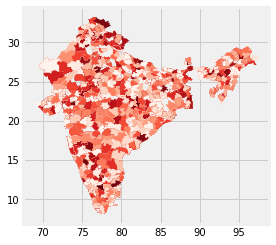

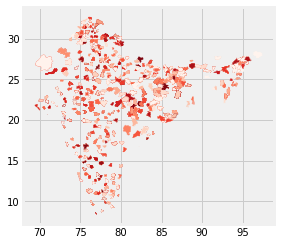

In [217]:
# Plot the number of cases of outbreaks
# localised to a sub-district

master_2 = ind_2.merge(df, on=['NAME_1','NAME_2'])
master_2.plot(column='num_cases',
                                             cmap='Reds'
                                             )

master_3 = ind_3.merge(df, on=['NAME_1','NAME_2','NAME_3'])
master_3.plot(column='num_cases',
                                             cmap='Reds'
                                             )

In [218]:
master_2.shape, master_3.shape

((9564, 30), (6725, 32))

In [219]:
master_2.columns

Index(['GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'NL_NAME_1', 'GID_2', 'NAME_2',
       'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2',
       'geometry', 'Unnamed: 0', 'unique_id', 'state', 'district',
       'disease_illness', 'num_cases', 'num_deaths',
       'date_of_start_of_outbreak', 'date_of_reporting', 'current_status',
       'comment_action_taken', 'reported_late', 'under_surveillance',
       'follow_up', 'source', 'NAME_3'],
      dtype='object')

In [220]:
cols = ['unique_id','NAME_1','NAME_2','NAME_3','geometry','disease_illness','num_cases','num_deaths','comment_action_taken','reported_late','under_surveillance','follow_up','source']

In [221]:
master = master_2.append(master_3)[cols].drop_duplicates('comment_action_taken')

In [222]:
master

,unique_id,NAME_1,NAME_2,NAME_3,geometry,disease_illness,num_cases,num_deaths,comment_action_taken,reported_late,under_surveillance,follow_up,source
0,AP/ANT/2016/34/1993,Andhra Pradesh,Anantapur,Anantapur,"POLYGON ((77.71420 13.76079, 77.71314 13.75074...",Leptospirosis,21,00,"Cases reported from SK University Hostel, V...",False,False,False,/users/rsg/anla/podcast/country_disease_outbre...
1,AP/ANT/2017/14/0449,Andhra Pradesh,Anantapur,Anantapur,"POLYGON ((77.71420 13.76079, 77.71314 13.75074...",Food Poisoning,31,00,"Cases reported from Village Gobberampalli,...",False,False,False,/users/rsg/anla/podcast/country_disease_outbre...
2,AP/ANT/2017/16/0532,Andhra Pradesh,Anantapur,Anantapur,"POLYGON ((77.71420 13.76079, 77.71314 13.75074...",Food Poisoning,33,00,Cases reported from Village/SC/PHC Mudinayanip...,False,False,False,/users/rsg/anla/podcast/country_disease_outbre...
3,AP/ANT/2017/41/1437,Andhra Pradesh,Anantapur,Anantapur,"POLYGON ((77.71420 13.76079, 77.71314 13.75074...",Any Other State Specific Disease,03,00,Cases reported from Village Chettlamorampa...,False,False,False,/users/rsg/anla/podcast/country_disease_outbre...
4,2.,Andhra Pradesh,Anantapur,None,"POLYGON ((77.71420 13.76079, 77.71314 13.75074...",Food Poisoning,39,0,Cases of stomach pain and vomiting reported fr...,False,False,False,/users/rsg/anla/podcast/country_disease_outbre...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9563,WB/WDN/2016/12/1254,West Bengal,Uttar Dinajpur,None,"MULTIPOLYGON (((88.45434 25.66317, 88.45428 25...",Snake bite,46,00,"Cases reported from Village Ranipur, SC Mirjat...",True,False,False,/users/rsg/anla/podcast/country_disease_outbre...
1439,2.,Dadra And Nagar Haveli,Dadra And Nagar Haveli,Silvassa,"POLYGON ((73.02468 20.09630, 73.01955 20.10502...",Measles,6,0,Cases of fever with rash reported from vil...,False,False,False,/users/rsg/anla/podcast/country_disease_outbre...
1440,3.,Daman And Diu,Daman,Daman,"POLYGON ((72.88378 20.37022, 72.87988 20.37077...",Dengue,"70 cases upto 28th Oct, 2012 (11lab confirmed...",0,Cases reported from Dalwada and Kachigaon ...,False,False,False,/users/rsg/anla/podcast/country_disease_outbre...
1441,1.,Daman And Diu,Diu,Diu,"POLYGON ((70.96264 20.72938, 70.96264 20.72903...",Viral Hepatitis,9,0,"Cases reported from Village Vanakbara, Dist...",NaN,NaN,False,/users/rsg/anla/podcast/country_disease_outbre...


In [223]:
master.to_file(f'idsp_database_camelot_{dt.today()}.shp')

## Plot cases

Dropdown(description='Disease:', index=4, options=('Acute Encephalitis Syndrome', 'Any Other State Specific Di…

<Figure size 576x576 with 0 Axes>

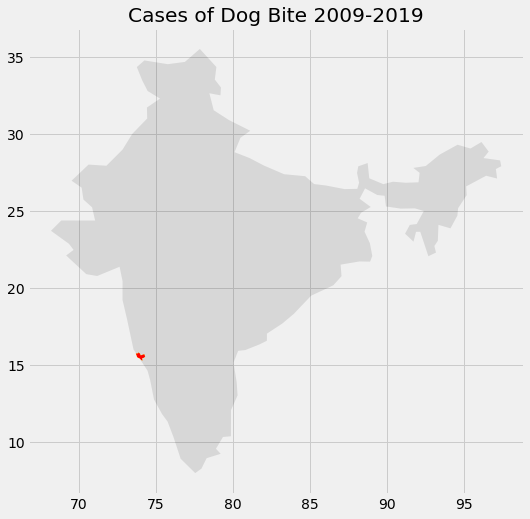

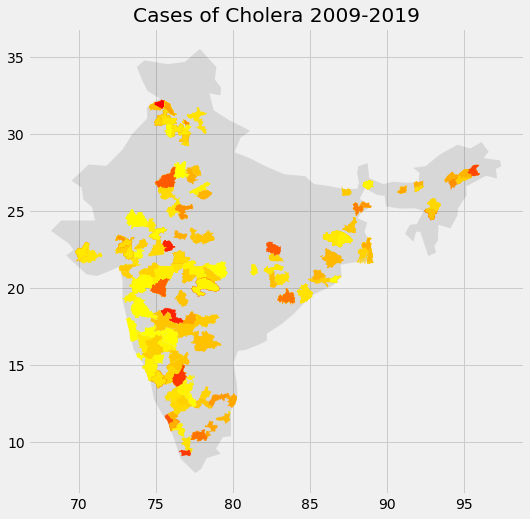

In [229]:
%matplotlib inline
plt.style.use('fivethirtyeight')
import ipywidgets as widgets
w = widgets.Dropdown(
    options=set(df.disease_illness),
    value='Cholera',
    description='Disease:',
    disabled=False,
)

       
from matplotlib.colors import LogNorm
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

plt.figure(figsize=(8,8))

def plot_cases(change):
    
    if change['type'] == 'change' and change['name'] == 'value':
        plt.figure(figsize=(8,8))
        plt.title(f'Cases of {change["new"]} 2009-2019')

        world[world.name == "India"].plot(ax=plt.gca(),
                                          color='k',
                                          alpha=0.1,
                                         )
        master[master.disease_illness == change['new']].plot(column='num_cases',
                                                             cmap='autumn',
                                                             norm=LogNorm(),
                                                             ax=plt.gca())
        plt.show()
    
w.observe(plot_cases)

display(w)

In [231]:
master[(master.disease_illness == 'Cholera') | (master.disease_illness == 'Acute Diarrheal Disease') | (master.disease_illness == 'Food Poisoning')].to_file(f'idsp_database_camelot_cleaned_geo_Cholera_ADD_FP_{dt.today()}.shp')

In [234]:
df[(df.disease_illness == 'Cholera') | (df.disease_illness == 'Acute Diarrheal Disease') | (df.disease_illness == 'Food Poisoning')].to_csv(f'idsp_database_camelot_cleaned_geo_Cholera_ADD_FP_{dt.today()}.csv')

# `### TAIL OF CURRENT WORKFLOW ###`

In [ ]:
df.num_cases

In [ ]:

# for backfilling missing state values from the district
district_state_dict = {}
for d in shps_2011[['state','district']].values:
    district_state_dict[d[1]] = d[0]

print('census 2011 districts')
district_names = set(shps.district); print(len(district_names))
print('census 2011 state')
state_names = set(shps.state); print(len(state_names))

print('df districts')
print(len(list(set(df.district))))

with open('disease_names.txt','r') as f:
    disease_names = f.read().split('\n')

In [ ]:
set(df.title)

In [ ]:
district_names = list(district_names)
district_names.sort()

In [ ]:
df_dist = [str(a) for a in list(set(df.district))]
df_dist.sort()
df_dist

In [ ]:
df.date_of_reporting.fillna('')

for i, row in df.iterrows():
    
    match = fuzzy_match(district_names, row.district)
    
    if match[-1] >= 85:
        df.at[i, 'district'] = match[0]

In [ ]:
len(list(set(df.district)))

In [ ]:
district_matches = []
for d in list(set(df.district.dropna())):
    district_matches.append((fuzzy_match(district_names, d)[::-1],d))
    print(d,'--->',fuzzy_match(district_names, d))

In [ ]:
district_matches.sort()
district_matches

In [ ]:
[a[0][0] for a in district_matches].index(69)

In [ ]:
plt.figure()
plt.ylabel('fuzzy match score')
plt.xlabel('record')
plt.plot([a[0][0] for a in district_matches])
plt.show()

## Fuzzy match state + district...

In [ ]:
state_district = []
for key in district_state_dict.keys():
    state_district.append(' '.join((district_state_dict[key],key)))
    
state_district.sort()

In [ ]:
sd_matches = []
for sd in (df.state.ffill() + ' ' + df.district).dropna():
    print(sd ,' ----> ',fuzzy_match(state_district, sd))
    sd_matches.append((fuzzy_match(state_district, sd)[::-1],sd))


In [ ]:
sd_matches.sort()

In [ ]:
sd_matches[[a[0][0] for a in sd_matches].index(100)]

In [ ]:
sd_matches[1600]

In [ ]:
plt.figure()
plt.ylabel('fuzzy match score')
plt.xlabel('record')
plt.plot([a[0][0] for a in sd_matches])
plt.show()

## Convert to datetime

In [ ]:
df.columns

In [ ]:
from dateutil.parser import parse

In [ ]:
df['date_of_start_of_outbreak'].dropna().iloc[545]

Here we use a regex to extract pairs of digits. Followed by a pd.to_datetime call with coersion to return nan for invalid input

In [ ]:
df['date_of_start_of_outbreak'] = pd.to_datetime(
    df['date_of_start_of_outbreak'].dropna().apply(
        lambda x:'-'.join(re.findall("\d{2}|\d{4}",x))
    ),
    errors='coerce'
)

In [ ]:
df.date_of_start_of_outbreak

## Split case/death column to cases | deaths

Try to split num_cases by / if possible, put first value to num_cases and second to num_deaths, shifting cells right to put dates in their correct columns

In [ ]:
df.date_of_reporting.fillna('')

for i, row in df.iterrows():
    try:
        # split cases / deaths column
        # use regex to extract digits
#         cases, deaths = row.num_cases.split('/')
        cases, deaths = re.findall('\d+',row.num_cases)
        # shuffle right dates to correct columns
        date_outbreak = row.num_deaths
        date_reporting = row.date_of_start_of_outbreak

        for j, var in enumerate(['num_cases',
                    'num_deaths',
                    'date_of_start_of_outbreak',
                    'date_of_reporting'
                   ]):
            df.at[i,var] = [int(cases),int(deaths),date_outbreak,date_reporting][j]
    except:
        pass

print(df.num_cases)

In [ ]:
def extract_digits(x):
    try:
        return re.findall('\d+',x)[0]
    except:
        return x

df.num_cases = df.num_cases.apply(extract_digits)
df[['num_cases','num_deaths']] = df[['num_cases','num_deaths']].apply(lambda x:pd.to_numeric(x,errors='coerce')).dropna()


## Cast to numeric data

First get rid of the text data in the numeric columns of cases, deaths.

In [ ]:
df.num_cases.values

In [ ]:
def to_numeric_soft(x,y):
    # take a column in dataframe, find all digits
    # convert the column to numeric datatype and return
    return pd.to_numeric(x[y].apply(lambda x:re.findall('\d*',str(x))[0]))

In [ ]:
df.num_cases = to_numeric_soft(df,'num_cases')
df.num_deaths = to_numeric_soft(df,'num_deaths')

Now we can look at the total cases and deaths from Cholera in out dataset.

In [ ]:
total_cases, total_deaths = df[df.disease_illness == 'Cholera'].sum(axis=0)[['num_cases','num_deaths']].values
print(f'Total cases = {total_cases},\ndeaths = {total_deaths},\nmortality rate = {total_deaths/total_cases*100} %')

In [ ]:
df.to_csv('idsp_database_v1.1.csv')

## Adding the geospatial element

There are a few ways we can connect the outbreak data with the region map of India.

IND_3 is a geopandas, geodataframe which has shape file geometry for the administrative regions of India. As per the following convention,

 * NAME_1 is the state
 * NAME_2 is the district
 * NAME_3 is the city


In [ ]:
IND_2

Most of the data columns in the IND_2 geodataframe are not populated and therefore not helpful.

## Quick plot

In [ ]:
IND_2.plot()

The two data frames can be merged using the dataframe method `.merge()`. By merging the two, we can attach the shape file for the district to the outbreaks in that district.

In this case we are interested in the _state_ and _district_ columns because that is the highest resolution the outbreak dataframe has. State must be included because some districts share the same name but are located in different states.

To do this _NAME\_1_ and _NAME\_2_ are renamded to _state_ and _district_ for compatibility with the outbreak dataframe. Next the multiple level 3 (settlements) data is removed. The dissolve method deals with multiple rows with the same district, keeping the geometry of the first row with a given district.

In [ ]:
district_locations = IND_2[['NAME_1','NAME_2','geometry']]\
                    .rename(columns={'NAME_1':'state','NAME_2':'district'})\
                    .dissolve(by=['state','district'],aggfunc='first')
district_locations

This geodataframe contains the unique names and geometry for each district in India. Now it must be merged with the outbreak data along the state and district columns

## Plot a random district and label it

To plot the districts themselves we can use `gpd.plotting.plot_dataframe()`.

In [ ]:
fig, ax = plt.subplots()

# choose a district at random
district = random.choice(district_locations.index)

gpd.plotting.plot_dataframe(district_locations,
                            ax=ax,
                           )
gpd.plotting.plot_polygon_collection(ax, district_locations.loc[[district],'geometry'],
                                     color='red'
                                    )

# district_locations.loc[[district]].centroid
plt.annotate(s=district, xy=(district_locations.loc[[district]].centroid.x,
                             district_locations.loc[[district]].centroid.y
                            )
            )

plt.show()

# Merge outbreaks with geospatial data on state and district columns

In [ ]:
master = district_locations.merge(outbreaks,on=['state','district'])

save to file for later use

In [ ]:
pwd

In [ ]:
master.to_file("IND_outbreaks.shp")

# Combination of data sets to map outbreaks

## Plot Cholera outbreaks

Lets plot the total cholera outbreaks. To do this we select the outbreaks that are cholera. Then take only the district and cases field before merging with the district locations. Now we have a composite dataframe that can make 

First lets figure out the total number of cholera cases

In [ ]:
outbreaks.cases = pd.to_numeric(outbreaks.cases,errors='coerce')
outbreaks[outbreaks.disease == 'Cholera'].cases.dropna().sum()

The district locations are ready to be merged with the outbreak data. In this case we just need the number of cholera cases so we select those before merging. That gives a consise geodataframe. Note that the geodataframe should be the one calling the merge() method, otherwise the result will be a normal dataframe, and loose its geo prefix and special abilities. This can be rectified it is just not quite so pleasing.

In [ ]:
composite = district_locations.merge(
    outbreaks[outbreaks['disease'] == 'Cholera'][['state','district','cases']],
    on=['state','district']
)
print(type(composite))

drop nan values and aggregate using .dissolve(). This gives us a single row for each district that contains the geometry and number of cases of cholera only.

In [ ]:
cholera_district_cases = composite.dropna().dissolve(by=['state','district'],aggfunc='sum')
print(type(cholera_district_cases))
print(cholera_district_cases.sum())

In [ ]:
fig, ax = plt.subplots(figsize=(5,5),dpi=150)

IND_2.plot(ax=ax,
           color='white',
           edgecolor='black',
           alpha=1,
           linewidth=0.05,
          )

cholera_district_cases.plot(column = 'cases',
                            cmap='Reds',
                            ax=ax,
                            legend=True,
#                             norm=SymLogNorm(1),
                           )

plt.title('Cholera cases 2009-present')

# label the 3 most infected districts
for index in cholera_district_cases.nlargest(3,columns='cases').index:
    gpd.plotting.plot_point_collection(ax,
                                       cholera_district_cases.loc[[index]].centroid,
#                                        color='black',
                                       marker='+',
                                       label=" ".join(index)+": "+str(cholera_district_cases.loc[[index]].cases.sum())
                                      )
    
#     plt.annotate(s= " ".join(index),
#                  xy=(cholera_district_cases.loc[[index]].centroid.x,
#                      cholera_district_cases.loc[[index]].centroid.y),
#                  horizontalalignment='left',
#                  verticalalignment='bottom'
#                 )

# get the total bounding box
x0,y0,x1,y1 = cholera_district_cases.total_bounds

# display total cases as an inset
plt.text(x0 + 1  * (x1-x0),
         y0 + 1  * (y1-y0),
         'total cases = '+str(int(cholera_district_cases.cases.sum())),
         horizontalalignment='right',
        )

plt.legend(loc=4)

plt.tight_layout()

plt.show()

Heatmap showing total Cholera cases by district from 2009 - present. The results with later version of the data analysis code seems to produce wildly different results. Which isn't reassuring. A ground truth metric against which the data can be compared would be very useful!

At this point we have some informative data. However it should be noted that this representation shows the total number of outbreaks by district. The districts themselves are not equal and this graphic shows neither the spatial density of cholera nor the infection rate.

In [ ]:
cholera_state_cases = cholera_district_cases.dissolve(by='state',aggfunc='sum')

In [ ]:
cholera_state_cases